In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [2]:
X = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/Training_Patches_2D_512x512/Images/*.tif'))
Y = sorted(glob('E:/Lempradl_Lab/April/OIC-78_Drosophila-brain-lesion-quant/Training_Patches_2D_512x512/Labels/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [4]:
#ImageJ's save image sequence altered the dtype of the 3D label images, used following cell to convert to 8-bit array

In [5]:
Y_labels = []
for img in Y:
    array = np.array(img)
    array = (array * 255).astype(np.uint8)
    Y_labels.append(array)

In [6]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y_labels)]

100%|███████████████████████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 791.88it/s]


In [ ]:
print(len(Y_labels))

In [7]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y_labels[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y_labels[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 402
- training:       342
- validation:      60


In [8]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()
    plt.show()

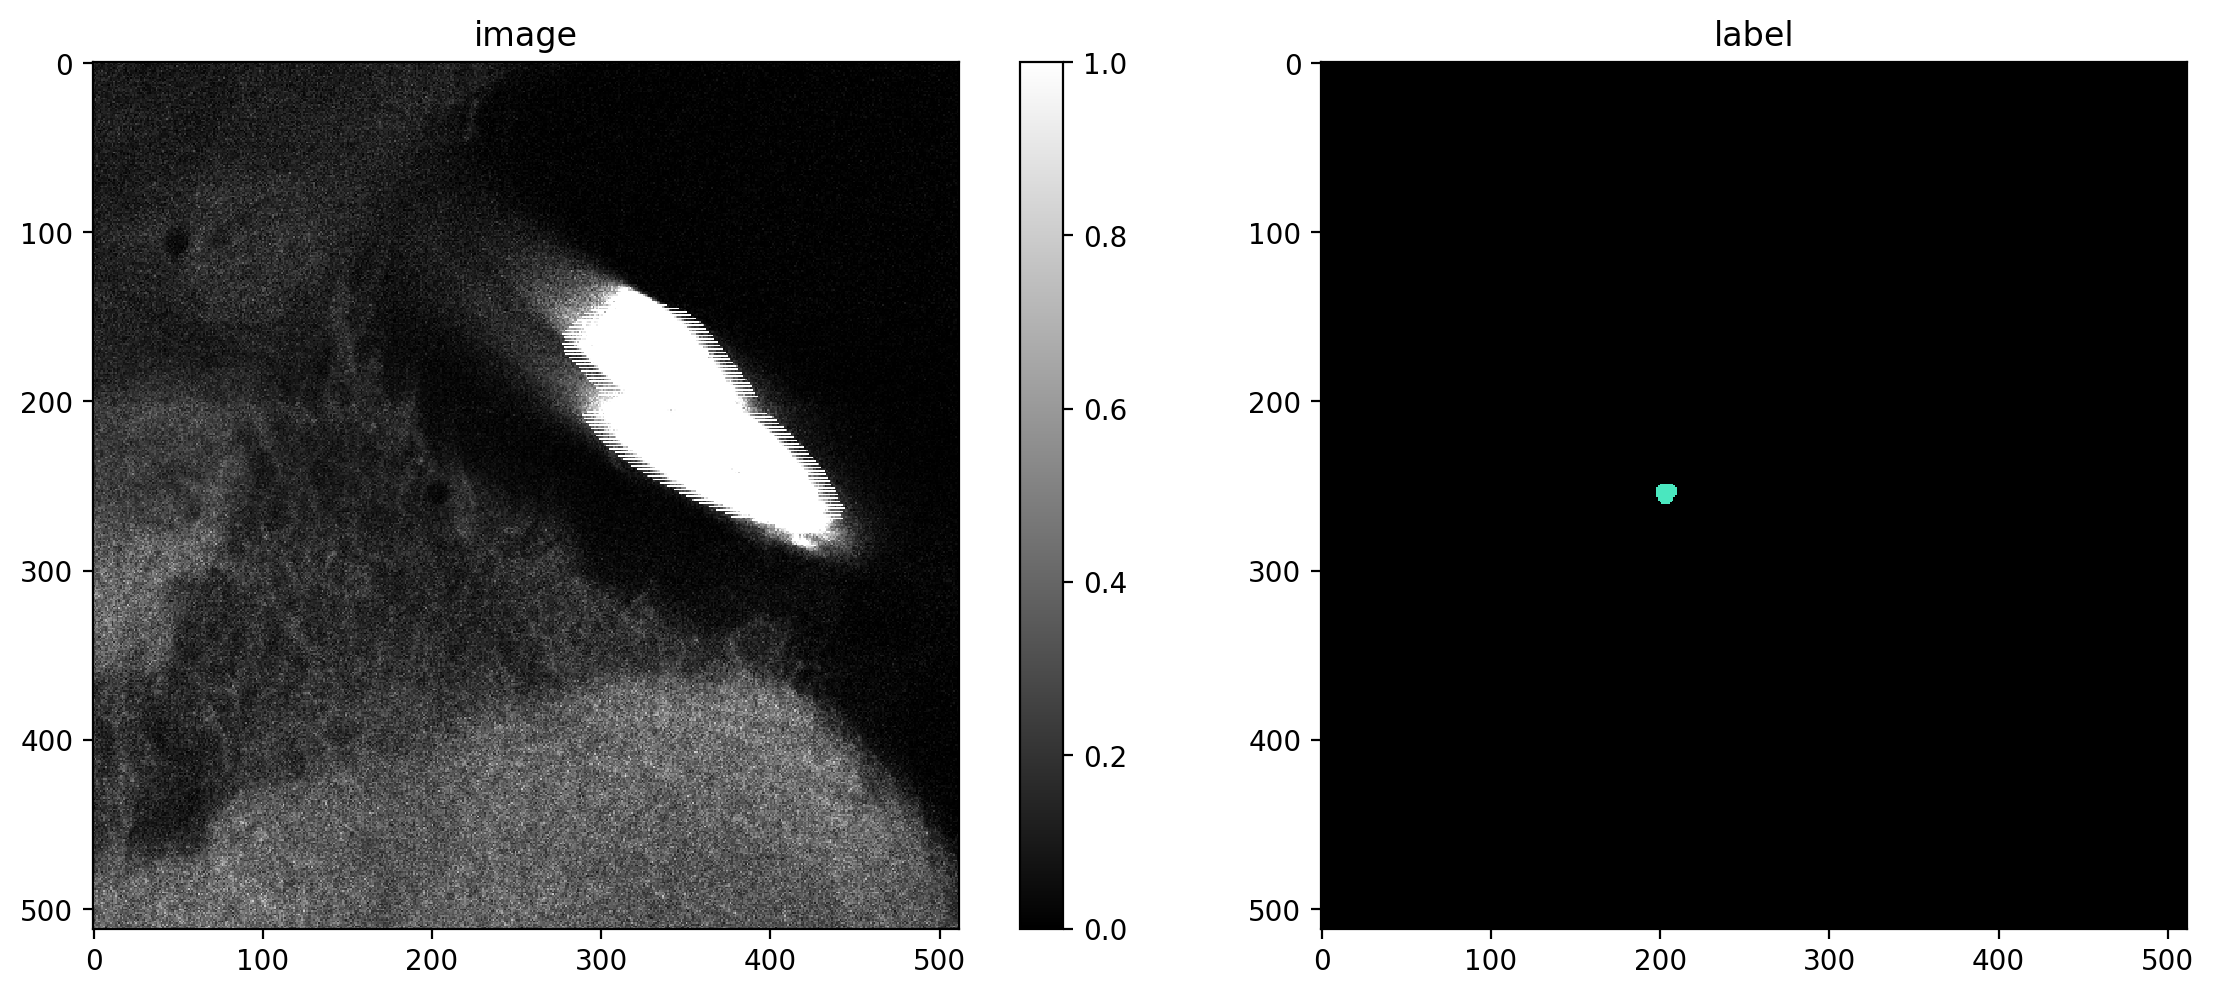

In [11]:
i = 111
img, lbl = X[i], Y_labels[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

In [12]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_patch_size = (256,256),
    train_steps_per_epoch = 100,
    train_epochs = 400,
)
print(conf)
vars(conf)

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_p

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [13]:
model = StarDist2D(conf, name='stardist2D_200steps_400epochs_training512x512_patches256x256_V2', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [14]:
median_size = calculate_extents(list(Y_labels), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [15.   13.75]
network field of view :  [94 92]


In [15]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [ ]:
# plot some augmented examples
img, lbl = X[55],Y_labels[55]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

In [16]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)

Epoch 1/400
100/100 [==============================] - 23s 176ms/step - loss: 1.3695 - prob_loss: 0.0729 - dist_loss: 6.4829 - prob_kld: 0.0705 - dist_relevant_mae: 6.4824 - dist_relevant_mse: 82.6748 - dist_dist_iou_metric: 0.1963 - val_loss: 1.3883 - val_prob_loss: 0.0205 - val_dist_loss: 6.8389 - val_prob_kld: 0.0180 - val_dist_relevant_mae: 6.8386 - val_dist_relevant_mse: 92.6914 - val_dist_dist_iou_metric: 0.0880 - lr: 3.0000e-04
Epoch 2/400
100/100 [==============================] - 9s 94ms/step - loss: 1.0556 - prob_loss: 0.0253 - dist_loss: 5.1516 - prob_kld: 0.0229 - dist_relevant_mae: 5.1510 - dist_relevant_mse: 52.8205 - dist_dist_iou_metric: 0.2720 - val_loss: 1.0401 - val_prob_loss: 0.0198 - val_dist_loss: 5.1015 - val_prob_kld: 0.0173 - val_dist_relevant_mae: 5.1006 - val_dist_relevant_mse: 48.8191 - val_dist_dist_iou_metric: 0.3529 - lr: 3.0000e-04
Epoch 3/400
100/100 [==============================] - 9s 96ms/step - loss: 1.0727 - prob_loss: 0.0236 - dist_loss: 5.2457 -

In [17]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████████████████████████████████         | 16/20 [00:02<00:00,  7.63it/s, 0.462 -> 0.219]


Using optimized values: prob_thresh=0.46066, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.46065981032062586, 'nms': 0.3}

In [18]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.24it/s]


In [19]:
import napari

In [20]:
viewer = napari.view_image(X_val[10], name= 'Val.Image')
viewer.add_image(Y_val[10], name='GT_Labels')
viewer.add_image(Y_val_pred[10], name= 'Predicted_Labels')
# plot_img_label(X_val[2],Y_val[2], lbl_title="label GT")
# plot_img_label(X_val[2],Y_val_pred[2], lbl_title="label Pred")

<Image layer 'Predicted_Labels' at 0x185cf24dde0>

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

In [ ]:
stats[taus.index(0.5)]

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

plt.show()